In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob, sys
import pandas as pd
sys.path.append("../scripts")

In [15]:
#Define key functions
def full_width_half_max(interpreted_depth, depth_array, count_array):
    """
    Function for calculating the interval that is >0.5 times the probability
    Parameters
    ----------
    interpreted_depth: float of the interpreted depth
    depth_array: array of depths
    count_array: array of counts. nb this is a proxy for probabilities

    Returns
    -------
    tuple of indices denoting the top and bottom of the full width half max
    """

    idx_upper = -1
    idx_lower = -1

    # Find the maximum depth index
    max_idx = np.argmin(np.abs(depth_array - interpreted_depth))

    # get the maximum probability
    fmax = count_array[max_idx]

    # Do some checks to make sure this depth is the most probably
    # within 9 cells

    window_slice = [max_idx - 4, max_idx + 4]
    # to ensure no index errors
    if window_slice[0] < 0:
        window_slice[0] = 0
    if window_slice[1] >= len(count_array):
        window_slice[1] = len(count_array)

    #if not fmax == np.max(count_array[window_slice[0]: window_slice][1]):
    #    return -999

    # positive direction
    for idx in np.arange(max_idx, depth_array.shape[0]):
        if count_array[idx] <= fmax/2.:
            idx_upper = idx
            break
    # negative direction
    for idx in np.arange(max_idx, -1, -1):
        if count_array[idx] <= fmax/2.:
            idx_lower = idx
            break
    # Now calculate the width
    return (idx_lower, max_idx, idx_upper)


In [21]:
# Define the directory with the data files

indir = r"E:\GA\MT\20Nov\Counts-depth"

In [31]:
# Load in the csv

infile = r"E:\GA\MT\20Nov\East Tennant_cover.csv"

df = pd.read_csv(infile)

# Create a new column with the path to the file

df['path'] = [os.path.join(indir,x + '.txt') for x in df['siteID']]

for fname in df['path'].values:
    if not os.path.isfile(fname):
        print(fname)

In [35]:
def generate_plot(max_idx, uncertainty_inds, depths, prob, outfile = None):

    fig, ax = plt.subplots(1,1, figsize = (6,12))

    ax.plot(prob,depths, 'k', label= 'layer point probability', linewidth = 1.5)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('normalised probability')
    # Add the uncertainties as horizontal lines
    ax.hlines(y = depths[max_idx], xmin = 0., xmax = prob.max(),
              colors ='red', label = 'cover', linestyle='dashed')
    ax.hlines(y = [depths[uncertainty_inds[0]], depths[uncertainty_inds[1]]],
              xmin = 0., xmax = prob.max(),
              colors ='green', label = 'full width half maximum',linestyle='dashed')
    ax.set_ylim(depths[uncertainty_inds[1]] + 500.,0)
    ax.legend()
    if outfile is not None:
        plt.savefig(outfile, dpi = 300)
    plt.close('all')

In [43]:
df['CoverThick_stdev'] = np.nan

for index, row in df.iterrows():
    arr = np.loadtxt(row['path'], skiprows = 1)
    depths = 10**arr[:,0]
    probability = arr[:,1]/np.max(arr[:,1]) # normalised probability
    interpreted_depth = row['Cover Thickness']
    [lower_ind, max_ind, upper_ind] = full_width_half_max(interpreted_depth, depths, probability)
    if np.logical_and(lower_ind != -1, upper_ind != -1):
        outfile = os.path.join(r"C:\temp\MT_uncert_plots", row['siteID'] + '.png')

        # Add to the dataframe
        df.at[index, 'CoverThick_stdev'] = depths[upper_ind] - depths[lower_ind]
        generate_plot(max_ind, [lower_ind, upper_ind],
                      depths, probability, outfile = outfile)


In [44]:
df.to_csv(r"C:\temp\MT_uncertinty_estimates.csv")

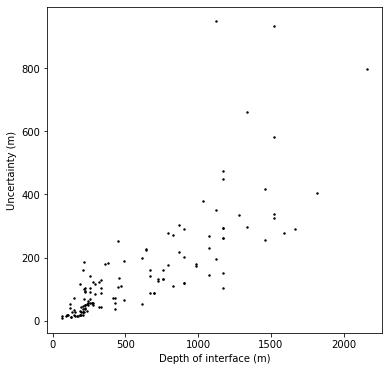

In [52]:
# PLot depth vs uncertainty
fig, ax = plt.subplots(1,1, figsize = (6,6))

ax.scatter(df['Cover Thickness'].values, df["CoverThick_stdev"].values,
           c = 'k', s = 2)

ax.set_xlabel('Depth of interface (m)')
ax.set_ylabel('Uncertainty (m)')
plt.savefig(r"C:\temp\MT_depth_v_uncertainty.png", dpi = 200)
plt.show()